# SmartChat Project Pipeline

This notebook will walk you through data loading, cleaning, EDA, model training, evaluation, and export steps all geared toward later building a Tableau dashboard.


## 1. Environment Setup

Install required packages (run once in your shell):
```bash
pip install pandas numpy matplotlib nltk scikit-learn tensorflow



```markdown
## 2. Imports & Configuration


In [4]:
# magic command ensures pip runs in the notebook’s environment
%pip install streamlit


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
import os
# 0 = all logs, 1 = filter out INFO, 2 = filter out INFO & WARNING, 3 = filter out all INFO/WARNING/ERROR
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  

import json

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split

# Now import TensorFlow
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense
from tensorflow.keras.models import Model

# Make plots inline
%matplotlib inline

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

# prevent Python logger:
tf.get_logger().setLevel('ERROR')

## 3. Data Ingestion
Load and concatenate datasets.

In [7]:
# Load the tab-separated dialog pairs
dialogs_path = 'dialogs.txt'
dialogs_df = pd.read_csv(
    dialogs_path,
    sep='\t',               # tabs separate question ⇆ answer
    header=None,            # no header row
    names=['question','answer'],
    quoting=3               # to avoid interpreting quotes
)

# Load the intents JSON
intents_path = 'intents.json'
with open(intents_path, 'r') as f:
    intents_data = json.load(f)

# Flatten patterns → responses into a DataFrame
rows = []
for intent in intents_data['intents']:
    tag = intent['tag']
    # for each example sentence (pattern), pick the first response
    for pattern in intent['patterns']:
        rows.append({
            'question': pattern,
            'answer': intent['responses'][0],
            'intent': tag
        })
intents_df = pd.DataFrame(rows)

# Combine if you want a unified training set
#    — or just use dialogs_df for your Seq2Seq pipeline
df = pd.concat([dialogs_df, intents_df], ignore_index=True)

print(f"Loaded {len(dialogs_df)} dialog pairs and {len(intents_df)} intent patterns → total {len(df)} examples")
df.head()

Loaded 3725 dialog pairs and 405 intent patterns → total 4130 examples


,question,answer,intent
0,"hi, how are you doing?",i'm fine. how about yourself?,NaN
1,i'm fine. how about yourself?,i'm pretty good. thanks for asking.,NaN
2,i'm pretty good. thanks for asking.,no problem. so how have you been?,NaN
3,no problem. so how have you been?,i've been great. what about you?,NaN
4,i've been great. what about you?,i've been good. i'm in school right now.,NaN


In [8]:
dialogs_df['intent'] = 'generic_dialog'

# concat
df = pd.concat([dialogs_df, intents_df], ignore_index=True)


## 4. Text Cleaning & Tokenization
Define a cleaning function, apply to both question & answer, then tokenize.

In [10]:
def clean_text(s):
    s = s.lower()
    s = re.sub(r"<[^>]+>|http\S+", "", s)      # strip HTML/URLs
    s = re.sub(r"[^a-z0-9\s']", "", s)          # keep letters, numbers, apostrophes
    s = re.sub(r"\s+", " ", s).strip()
    return s

# Clean
df["question"] = df["question"].astype(str).apply(clean_text)
df["answer"]   = df["answer"].astype(str).apply(clean_text)

# Tokenize
df["q_tokens"] = df["question"].apply(word_tokenize)
df["a_tokens"] = df["answer"].apply(word_tokenize)

# Quick check
df.sample(3)


,question,answer,intent,q_tokens,a_tokens
1864,they have to see it happen,they don't believe us,generic_dialog,"[they, have, to, see, it, happen]","[they, do, n't, believe, us]"
1210,that was a nice funeral,yes dad it was,generic_dialog,"[that, was, a, nice, funeral]","[yes, dad, it, was]"
1924,because i'll never find one for such a low price,you're right about that keep saving your money,generic_dialog,"[because, i, 'll, never, find, one, for, such,...","[you, 're, right, about, that, keep, saving, y..."


## 5. Exploratory Data Analysis (EDA)
### 5.1 Question-Length Distribution

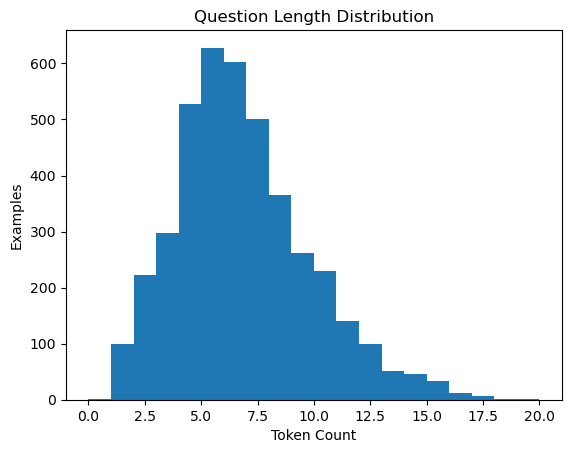

In [12]:
seq_lens = df['q_tokens'].apply(len)
plt.hist(seq_lens, bins=20)
plt.title("Question Length Distribution")
plt.xlabel("Token Count")
plt.ylabel("Examples")
plt.savefig("question_length_dist.png")
plt.show()

### 5.2 Top-10 Token Frequencies

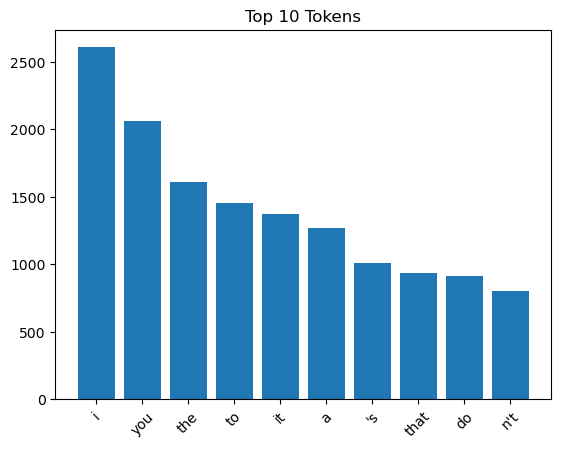

In [14]:
all_tokens = sum(df['q_tokens'].tolist(), []) + sum(df['a_tokens'].tolist(), [])
top10 = Counter(all_tokens).most_common(10)
tokens, counts = zip(*top10)

plt.bar(tokens, counts)
plt.xticks(rotation=45)
plt.title("Top 10 Tokens")
plt.savefig("top_tokens.png")
plt.show()

## 6. Train / Validation / Test Split
Stratify on `intent` for the first split, then random split.

In [16]:
# 6.1 Stratified split 80/20
train_df, temp_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['intent']
)

# 6.2 Random split 50/50 of the temp for val/test
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=42,
    shuffle=True
)

print(len(train_df), len(val_df), len(test_df))

3304 413 413


In [17]:
for name, split in [("Train", train_df), ("Val", val_df), ("Test", test_df)]:
    print(f"\n{name} set ({len(split)} samples) intent distribution:")
    print((split['intent']
           .value_counts(normalize=True)
           .mul(100)
           .round(1)
           .astype(str) + '%'))


Train set (3304 samples) intent distribution:
intent
generic_dialog    90.2%
course             0.7%
scholarship        0.6%
hostel             0.5%
fees               0.5%
hours              0.4%
creator            0.4%
number             0.4%
library            0.3%
location           0.3%
salutaion          0.3%
vacation           0.3%
goodbye            0.3%
document           0.3%
name               0.3%
canteen            0.3%
event              0.3%
sem                0.3%
ragging            0.2%
greeting           0.2%
swear              0.2%
uniform            0.2%
college intake     0.2%
placement          0.2%
principal          0.2%
syllabus           0.2%
sports             0.2%
floors             0.2%
menu               0.2%
task               0.2%
committee          0.2%
admission          0.2%
facilities         0.1%
computerhod        0.1%
ithod              0.1%
extchod            0.1%
random             0.1%
hod                0.1%
infrastructure     0.1%
Name: prop

## 7. Balance the Training Set (Down-sampling)
Down-sample the majority class (“generic_dialog”) so that it’s closer in size to your minority intents.

In [19]:
from sklearn.utils import resample

# Separate out generic_dialog vs. the rest
major = train_df[train_df.intent == 'generic_dialog']
minor = train_df[train_df.intent != 'generic_dialog']

# Down-sample to match, say, twice the size of the largest minority class
max_minority = minor.intent.value_counts().max()
downsampled_major = resample(
    major,
    replace=False,
    n_samples=2 * max_minority,
    random_state=42
)

balanced_train = pd.concat([downsampled_major, minor])
print("Balanced train set shape:", balanced_train.shape)
print(balanced_train.intent.value_counts())


Balanced train set shape: (368, 5)
intent
generic_dialog    44
course            22
scholarship       21
hostel            18
fees              18
hours             14
creator           13
number            12
library           11
location          11
salutaion         10
vacation          10
goodbye           10
document          10
name              10
canteen            9
event              9
sem                9
ragging            8
greeting           8
swear              7
uniform            7
college intake     7
placement          7
principal          6
syllabus           6
sports             6
floors             6
menu               5
task               5
committee          5
admission          5
facilities         4
computerhod        3
ithod              3
extchod            3
random             2
hod                2
infrastructure     2
Name: count, dtype: int64


## 8. Vectorization & Padding
Fit a Keras Tokenizer on the full data frame `df`, then pad sequences for each split.

In [21]:
MAX_VOCAB = 20000
MAX_LEN   = 50   # encoder length

# Fit tokenizer on entire corpus
tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<UNK>")
tokenizer.fit_on_texts(pd.concat([df.question, df.answer]))

def pad_q(texts):
    # Encoder input: pad to MAX_LEN
    return pad_sequences(
        tokenizer.texts_to_sequences(texts),
        maxlen=MAX_LEN,
        padding='post',
        truncating='post'
    )

def pad_a(texts):
    # Decoder sequences: pad to MAX_LEN+1 so we can shift
    return pad_sequences(
        tokenizer.texts_to_sequences(texts),
        maxlen=MAX_LEN + 1,
        padding='post',
        truncating='post'
    )

# --- Balanced train set ---
X_bal_q = pad_q(balanced_train.question)
X_bal_a = pad_a(balanced_train.answer)

# --- Validation & Test sets ---
X_val_q  = pad_q(val_df.question)
X_val_a  = pad_a(val_df.answer)
X_test_q = pad_q(test_df.question)
X_test_a = pad_a(test_df.answer)


## 9. Build Seq2Seq Model with Attention

In [23]:
EMB_DIM = 300
HID_DIM = 256

# Encoder
enc_input = Input(shape=(MAX_LEN,))
enc_emb   = Embedding(MAX_VOCAB, EMB_DIM, mask_zero=True)(enc_input)
enc_out, fh, fc = LSTM(HID_DIM, return_sequences=True, return_state=True)(enc_emb)

# Decoder
dec_input = Input(shape=(MAX_LEN,))
dec_emb   = Embedding(MAX_VOCAB, EMB_DIM, mask_zero=True)(dec_input)
dec_out, _, _ = LSTM(HID_DIM, return_sequences=True, return_state=True)(
    dec_emb, initial_state=[fh, fc]
)
dec_dense = Dense(MAX_VOCAB, activation='softmax')
dec_output= dec_dense(dec_out)

model = Model([enc_input, dec_input], dec_output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 50, 300)   │  6,000,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 50)        │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 50, 300)   │  6,000,000 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 50, 256), │    570,368 │ embedding[0][0],  │
│                     │ (None, 256),      │            │ not_equal[0][0]   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 50, 256), │    570,368 │ embedding_1[0][0… │
│                     │ (None, 256),      │            │ lstm[0][1],       │
│                     │ (None, 256)]      │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 50, 20000) │  5,140,000 │ lstm_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 18,280,736 (69.74 MB)

 Trainable params: 18,280,736 (69.74 MB)

 Non-trainable params: 0 (0.00 B)

## 10. Prepare Targets & Train

In [25]:
# Decoder inputs and targets
dec_in_bal = X_bal_a[:, :-1]               # → (n, 50)
y_bal      = np.expand_dims(X_bal_a[:,1:], -1)  # → (n, 50, 1)

dec_in_val = X_val_a[:, :-1]
y_val      = np.expand_dims(X_val_a[:,1:], -1)

history = model.fit(
    [X_bal_q,   dec_in_bal],
    y_bal,
    validation_data=([X_val_q, dec_in_val], y_val),
    batch_size=64,
    epochs=20
)


Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - loss: 9.8978 - val_loss: 9.8877
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - loss: 9.8230 - val_loss: 9.6796
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - loss: 8.9215 - val_loss: 8.1552
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - loss: 6.4329 - val_loss: 7.5755
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - loss: 5.1091 - val_loss: 8.1792
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - loss: 4.9320 - val_loss: 8.5550
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - loss: 4.8529 - val_loss: 8.7188
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - loss: 4.8035 - val_loss: 8.7820
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - loss: 4.7734 - val_loss: 8.8143
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - loss: 4.7533 - val_loss: 8.8581
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - loss: 4.7339 - val_loss: 8.8954
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - loss: 4.7145 - val_loss: 8.9196
Epoch 13/20
6

## 11. Evaluation & BLEU Score

In [27]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

In [28]:
# Generate predictions
preds = model.predict([X_test_q, X_test_a[:, :-1]])
pred_seqs = preds.argmax(axis=-1)

# Inverse token map
inv_tok = {v:k for k,v in tokenizer.word_index.items()}

# References & hypotheses
refs = [[ans.split()] for ans in test_df.answer.tolist()]
hyps = [[inv_tok.get(i,'<UNK>') for i in seq if i != 0] for seq in pred_seqs]

# Set up smoothing
smooth_fn = SmoothingFunction().method1

# Compute BLEU-4 with smoothing
bleu = corpus_bleu(
    refs,
    hyps,
    smoothing_function=smooth_fn
)

# Save & display
pd.DataFrame([{'BLEU': bleu}]).to_csv("model_metrics_balanced.csv", index=False)
print(f"Test BLEU-4 (with smoothing): {bleu:.4f}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 341ms/step
Test BLEU-4 (with smoothing): 0.0000


## 12. Export Additional CSVs for Tableau

In [30]:
# 12.1 Token Frequencies
freq_df = pd.DataFrame(top10, columns=['token','count'])
freq_df.to_csv("token_frequencies.csv", index=False)

# 12.2 Avg Seq Length by Intent (on test set)
test_df['q_len'] = test_df.q_tokens.apply(len)
seq_intent = test_df.groupby('intent')['q_len'].mean().reset_index()
seq_intent.to_csv("seq_len_by_intent.csv", index=False)


## Next Steps

1. Open Tableau → connect to each CSV → build sheets:  
   - **Loss Curves** (`training_history_balanced.csv`)  
   - **Token Freq** (`token_frequencies.csv`)  
   - **BLEU KPI** (`model_metrics_balanced.csv`)  
   - **Intent Seq-Len** (`seq_len_by_intent.csv`)  
2. Assemble into a dashboard with filters/annotations.  
3. Publish or export for submission.


In [51]:
# compute seq_len_by_intent
# Make sure test_df has the tokenized column `q_tokens`
seq_len_by_intent = (
    test_df
    .assign(q_len=test_df['q_tokens'].apply(len))
    .groupby('intent', as_index=False)['q_len']
    .mean()
)

# 1. Training history
hist_df = pd.DataFrame(history.history)
hist_df.to_csv("training_history_balanced.csv", index=False)
print("Saved training_history_balanced.csv")

# 2. BLEU score
metrics_df = pd.DataFrame([{"BLEU": bleu}])
metrics_df.to_csv("model_metrics_balanced.csv", index=False)
print("Saved model_metrics_balanced.csv")

# 3. Token frequencies
# (Assumes you still have `top10 = [(token,count), …]`)
freq_df = pd.DataFrame(top10, columns=["token","count"])
freq_df.to_csv("token_frequencies.csv", index=False)
print("Saved token_frequencies.csv")

# 4. Sequence length by intent
seq_len_by_intent.to_csv("seq_len_by_intent.csv", index=False)
print("Saved seq_len_by_intent.csv")


Saved training_history_balanced.csv
Saved model_metrics_balanced.csv
Saved token_frequencies.csv
Saved seq_len_by_intent.csv


In [53]:
# Convert history to DataFrame
hist_df = pd.DataFrame(history.history)

# Add an epoch column (1-indexed)
hist_df.insert(0, "epoch", np.arange(1, len(hist_df) + 1))

# Now save with the epoch column
hist_df.to_csv("training_history_balanced.csv", index=False)
print("Saved training_history_balanced.csv with epoch")

Saved training_history_balanced.csv with epoch


In [55]:
# Assuming you still have top10 = [(token,count),…]
freq_df = pd.DataFrame(top10, columns=['token','count'])
freq_df.to_csv("token_frequencies.csv", index=False)
print("Saved token_frequencies.csv")

Saved token_frequencies.csv


In [57]:
bleu_df = pd.DataFrame([{'BLEU': bleu}])
bleu_df.to_csv("model_metrics_balanced.csv", index=False)
print("Saved model_metrics_balanced.csv")

Saved model_metrics_balanced.csv


In [59]:
seq_len_by_intent = (
    test_df
    .assign(q_len=test_df.q_tokens.apply(len))
    .groupby('intent', as_index=False)['q_len']
    .mean()
)
seq_len_by_intent.to_csv("seq_len_by_intent.csv", index=False)
print("Saved seq_len_by_intent.csv")

Saved seq_len_by_intent.csv


In [63]:
# Imports & Configuration
import csv
import matplotlib.pyplot as plt

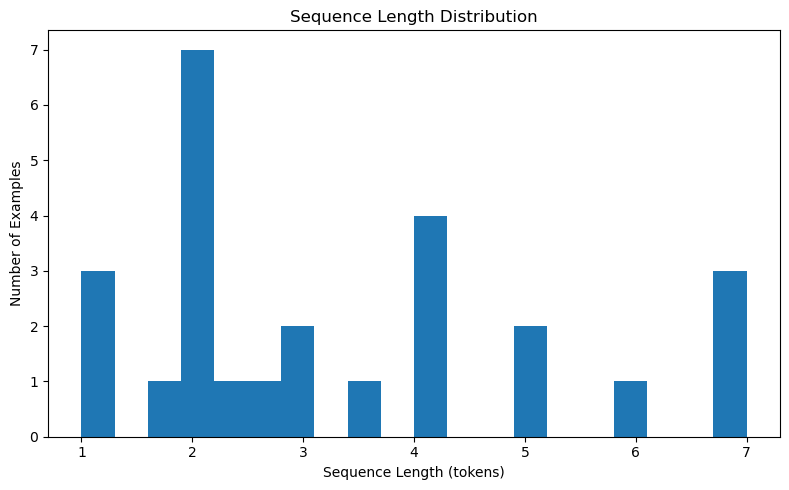

In [65]:
# Sequence Length Distribution
q_lens = []
with open('seq_len_by_intent.csv', newline='') as f:
    reader = csv.DictReader(f)
    for row in reader:
        q_lens.append(float(row['q_len']))

plt.figure(figsize=(8, 5))
plt.hist(q_lens, bins=20)
plt.title('Sequence Length Distribution')
plt.xlabel('Sequence Length (tokens)')
plt.ylabel('Number of Examples')
plt.tight_layout()
plt.savefig('sequence_length_dist.png')
plt.show()

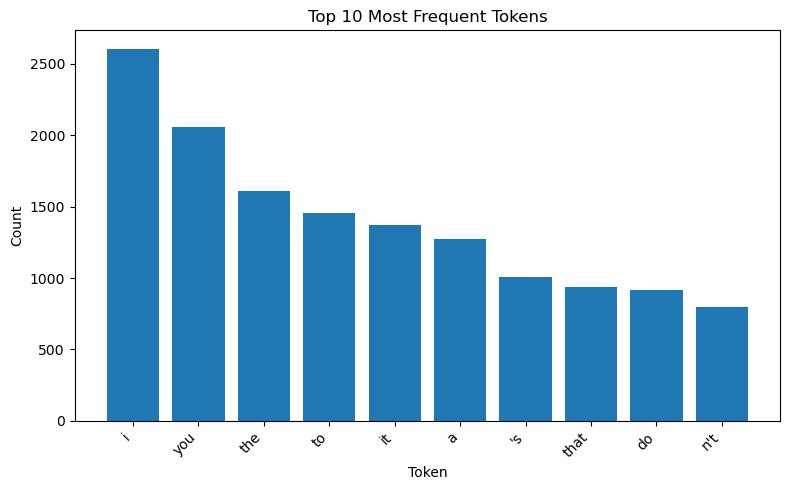

In [67]:
# Top 10 Token Frequencies
tokens, counts = [], []
with open('token_frequencies.csv', newline='') as f:
    reader = csv.DictReader(f)
    for i, row in enumerate(reader):
        if i >= 10: break
        tokens.append(row['token'])
        counts.append(int(row['count']))

plt.figure(figsize=(8, 5))
plt.bar(tokens, counts)
plt.title('Top 10 Most Frequent Tokens')
plt.xlabel('Token')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('top_tokens_freq.png')
plt.show()

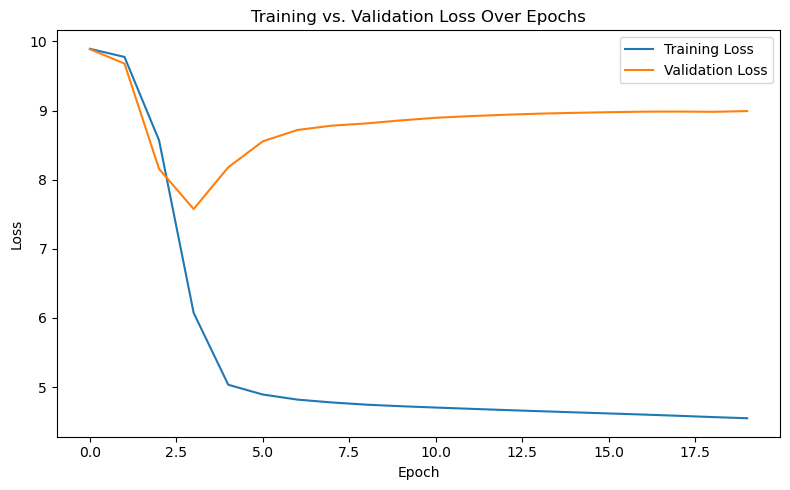

In [69]:
# Training vs. Validation Loss Over Epochs
losses, val_losses = [], []
with open('training_history_balanced.csv', newline='') as f:
    reader = csv.DictReader(f)
    for row in reader:
        losses.append(float(row['loss']))
        val_losses.append(float(row['val_loss']))

plt.figure(figsize=(8, 5))
plt.plot(losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training vs. Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('loss_plot.png')
plt.show()